In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style
import warnings

mpl.style.use('seaborn-v0_8-darkgrid')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
from preproc import ANALYSIS_COLUMNS

import datetime as dt
import pandas as pd
import numpy as np

USER_DISPLAY_NAME = 'screen_name'
ANALYSIS_START_DATE = dt.datetime.fromisoformat('2022-11-01T00:00:00+00:00')
ANALYSIS_END_DATE = dt.datetime.fromisoformat('2022-11-30T23:59:59+00:00')

users = pd.read_csv('preproc_users_view.csv')
tweets_view = pd.read_csv('preproc_tweets_view.csv', parse_dates=['created_at'])
tweets_view = tweets_view[
    (tweets_view.created_at >= ANALYSIS_START_DATE)
    & (tweets_view.created_at <= ANALYSIS_END_DATE)
]
users_view = users[users.user_id.isin(tweets_view.user_id.unique())].copy()

users_view = users_view[ANALYSIS_COLUMNS['users']]
tweets_view = tweets_view[ANALYSIS_COLUMNS['tweets'] + ['user_id', 'screen_name', 'followers_count', 'friends_count']]

HASHTAG_COLUMN_NAME = 'all_hashtags'
users_view[HASHTAG_COLUMN_NAME] = users_view[HASHTAG_COLUMN_NAME].map(eval)
tweets_view[HASHTAG_COLUMN_NAME] = tweets_view[HASHTAG_COLUMN_NAME].map(eval)

# users_view['hashtags'] = users_view['hashtags'].map(eval)
# users_view['original_hashtags'] = users_view['original_hashtags'].map(eval)
# users_view['retweet_hashtags'] = users_view['retweet_hashtags'].map(eval)
# users_view['quote_hashtags'] = users_view['quote_hashtags'].map(eval)
# users_view['all_hashtags'] = users_view['all_hashtags'].map(eval)

# tweets_view['hashtags'] = tweets_view['hashtags'].map(eval)
# tweets_view['original_hashtags'] = tweets_view['original_hashtags'].map(eval)
# tweets_view['retweet_hashtags'] = tweets_view['retweet_hashtags'].map(eval)
# tweets_view['quote_hashtags'] = tweets_view['quote_hashtags'].map(eval)
# tweets_view['all_hashtags'] = tweets_view['all_hashtags'].map(eval)
# tweets_view['lemmatized_text'] = tweets_view['lemmatized_text'].map(eval)

# users_view['user_mentions'] = users_view['user_mentions'].map(eval)
# users_view['original_user_mentions'] = users_view['original_user_mentions'].map(eval)
# users_view['retweet_user_mentions'] = users_view['retweet_user_mentions'].map(eval)
# users_view['quote_user_mentions'] = users_view['quote_user_mentions'].map(eval)

# tweets_view['user_mentions'] = tweets_view['user_mentions'].map(eval)
# tweets_view['original_user_mentions'] = tweets_view['original_user_mentions'].map(eval)
# tweets_view['retweet_user_mentions'] = tweets_view['retweet_user_mentions'].map(eval)
# tweets_view['quote_user_mentions'] = tweets_view['quote_user_mentions'].map(eval)

stats_df = pd.DataFrame(
    [
        '{:,}'.format(len(users[users.is_croatian == True])),
        '{:,}'.format(len(users_view)),
        '{:,}'.format(len(tweets_view)),
        
        # '{0:.2f}%'.format(100*(tweets_view['is_original'].sum() / (tweets_view['is_original'].sum() + tweets_view['is_retweet'].sum()))),
        # '{0:.2f}%'.format(100*(tweets_view['is_retweet'].sum() / (tweets_view['is_original'].sum() + tweets_view['is_retweet'].sum()))),
        '{:,}'.format(tweets_view['is_original'].sum()),
        '{:,}'.format(tweets_view['is_retweet'].sum()),
        '{:,}'.format(tweets_view['is_reply'].sum()),
        '{:,}'.format(tweets_view['is_quote'].sum()),
        
        '{:,}'.format(tweets_view['in_retweet_cnt'].sum()),
        '{:,}'.format(tweets_view['in_reply_cnt'].sum()),
        '{:,}'.format(tweets_view['in_quote_cnt'].sum()),
        
        tweets_view.created_at.min(),
        tweets_view.created_at.max()

    ],
    index=[
        "Croatian Users (global) #",
        "Croatian Users (tweets) #",
        "Tweets #",
        
        "Original #",
        "Reweets #",
        "Replies #",
        "Quotes #",
        
        "In Reweets #",
        "In Replies #",
        "In Quotes #",
        
        "Earliest Tweet date",
        "Latest Tweet date"
    ],
    columns=['Tweets Data']
)

stats_df

,Tweets Data
Croatian Users (global) #,"50,010"
Croatian Users (tweets) #,"7,067"
Tweets #,"402,961"
Original #,"278,553"
Reweets #,"124,408"
Replies #,"175,890"
Quotes #,"24,965"
In Reweets #,"7,161.0"
In Replies #,"33,171"
In Quotes #,"2,174.0"


In [3]:
hashtags_view = tweets_view.explode(HASHTAG_COLUMN_NAME) \
    .rename(
        columns={HASHTAG_COLUMN_NAME: 'hashtag'}
    ).groupby(
        ['year', 'month', 'week', 'day', 'hashtag', USER_DISPLAY_NAME]
    ).agg(
        total_out_tweets_cnt=('hashtag', 'count'),
        total_in_tweets_cnt=('total_in_tweets_cnt', 'sum'),
        
        followers_cnt=('followers_count', 'mean'),
        friends_cnt=('friends_count', 'mean'),
        
        original_tweets_cnt=('is_original', 'sum'),
        out_retweet_cnt=('is_retweet', 'sum'),
        out_reply_cnt=('is_reply', 'sum'),
        out_quote_cnt=('is_quote', 'sum'),
        out_original_favorite_cnt=('original_favorite_cnt', 'sum'),

        in_retweet_cnt=('in_retweet_cnt', 'sum'),
        in_reply_cnt=('in_reply_cnt', 'sum'),
        in_quote_cnt=('in_quote_cnt', 'sum'),
        in_retweet_favorite_cnt=('retweet_favorite_cnt', 'sum'),
        in_quote_favorite_cnt=('quote_favorite_cnt', 'sum'),
        
        in_retweet_timedelta_sec=('in_retweet_timedelta_sec', 'mean'),
        in_quote_timedelta_sec=('in_quote_timedelta_sec', 'mean')
    )


AGGREGATE = dict(
    total_out_tweets_cnt=('total_out_tweets_cnt', 'sum'),
    total_in_tweets_cnt=('total_in_tweets_cnt', 'sum'),
    
    followers_cnt=('followers_cnt', 'mean'),
    friends_cnt=('friends_cnt', 'mean'),
    
    original_tweets_cnt=('original_tweets_cnt', 'sum'),
    out_retweet_cnt=('out_retweet_cnt', 'sum'),
    out_reply_cnt=('out_reply_cnt', 'sum'),
    out_quote_cnt=('out_quote_cnt', 'sum'),
    out_favorite_cnt=('out_original_favorite_cnt', 'sum'),

    in_retweet_cnt=('in_retweet_cnt', 'sum'),
    in_reply_cnt=('in_reply_cnt', 'sum'),
    in_quote_cnt=('in_quote_cnt', 'sum'),
    in_retweet_favorite_cnt=('in_retweet_favorite_cnt', 'sum'),
    in_quote_favorite_cnt=('in_quote_favorite_cnt', 'sum'),    
    
    in_retweet_timedelta_sec=('in_retweet_timedelta_sec', 'mean'),
    in_quote_timedelta_sec=('in_quote_timedelta_sec', 'mean')
)
hashtags_view.sample(7)

total_out_tweets_cnt  \
year month week day hashtag      screen_name                          
2022 11    46   20  RaiderNation frikeyyy                         1   
           44   6   locations    RetreatLovin                     1   
           45   10  predavanje   HRenertrans                      1   
           47   27  Christmas    Jasnaart                         1   
           45   8   eclipse      PetraLidia                       1   
           46   18  Škabrnji     DNEVNIKhr                        1   
           48   29  plvsaa       BerlitzXV                        1   

                                               total_in_tweets_cnt  \
year month week day hashtag      screen_name                         
2022 11    46   20  RaiderNation frikeyyy                      0.0   
           44   6   locations    RetreatLovin                  0.0   
           45   10  predavanje   HRenertrans                   1.0   
           47   27  Christmas    Jasnaart                      0.0   
           45   8   eclipse      PetraLidia                    0.0   
           46   18  Škabrnji     DNEVNIKhr                     0.0   
           48   29  plvsaa       BerlitzXV                     0.0   

                                               followers_cnt  friends_cnt  \
year month week day hashtag      screen_name                                
2022 11    46   20  RaiderNation frikeyyy               17.0        127.0   
           44   6   locations    RetreatLovin          272.0       1031.0   
           45   10  predavanje   HRenertrans           416.0        728.0   
           47   27  Christmas    Jasnaart             7072.0       6103.0   
           45   8   eclipse      PetraLidia            189.0        199.0   
           46   18  Škabrnji     DNEVNIKhr          259423.0       1141.0   
           48   29  plvsaa       BerlitzXV              42.0       2773.0   

                                               original_tweets_cnt  \
year month week day hashtag      screen_name                         
2022 11    46   20  RaiderNation frikeyyy                        1   
           44   6   locations    RetreatLovin                    1   
           45   10  predavanje   HRenertrans                     1   
           47   27  Christmas    Jasnaart                        0   
           45   8   eclipse      PetraLidia                      1   
           46   18  Škabrnji     DNEVNIKhr                       0   
           48   29  plvsaa       BerlitzXV                       0   

                                               out_retweet_cnt  out_reply_cnt  \
year month week day hashtag      screen_name                                    
2022 11    46   20  RaiderNation frikeyyy                    0              0   
           44   6   locations    RetreatLovin                0              0   
           45   10  predavanje   HRenertrans                 0              0   
           47   27  Christmas    Jasnaart                    1              0   
           45   8   eclipse      PetraLidia                  0              0   
           46   18  Škabrnji     DNEVNIKhr                   1              0   
           48   29  plvsaa       BerlitzXV                   1              0   

                                               out_quote_cnt  \
year month week day hashtag      screen_name                   
2022 11    46   20  RaiderNation frikeyyy                  0   
           44   6   locations    RetreatLovin              0   
           45   10  predavanje   HRenertrans               1   
           47   27  Christmas    Jasnaart                  0   
           45   8   eclipse      PetraLidia                0   
           46   18  Škabrnji     DNEVNIKhr                 0   
           48   29  plvsaa       BerlitzXV                 0   

                                               out_original_favorite_cnt  \
year month week day hashtag      screen_name                        

In [4]:
PLOT_CONFIG = {
    'plot_head': 12,
    'inbound_cols': {
        'in_retweet_cnt': 'Retweeted', 
        'in_reply_cnt': 'Replied', 
        'in_quote_cnt': 'Quoted'
    },
    'outbound_cols': {
        # 'out_retweets_cnt': 'Retweet', 
        # 'out_replies_cnt': 'Reply', 
        # 'out_quotes_cnt': 'Quote',
        'original_tweets_cnt': 'Original'
    },
    'total_cols': {
        'total_out_tweets_cnt': 'Total number of Outgoing Hashtags',
        'total_in_tweets_cnt': 'Total number of Incoming Hashtags'
    }
}

rename_map = dict(PLOT_CONFIG['inbound_cols'], **PLOT_CONFIG['outbound_cols'])

def plot_top_tweet_hashtags(df, title, max_x, export_plot_name=None):
    fig, ax = plt.subplots(1, figsize=(14, 8))

    top_tweets_df = df[rename_map.keys()].copy()
    for col_name in PLOT_CONFIG['outbound_cols']:
        top_tweets_df[col_name] = top_tweets_df[col_name] * -1
    top_tweets_df = top_tweets_df.rename(columns=rename_map)
    
    x1000 = max_x % 1000
    max_x = ((max_x-x1000) // 1000) * 1000 + 1000
    min_x = max_x * -1
    
    inbound_cols  = PLOT_CONFIG['inbound_cols'].values()
    outbound_cols = PLOT_CONFIG['outbound_cols'].values()
    
    top_tweets_df[outbound_cols].plot.barh(
        ax=ax, 
        # alpha=0.5,
        stacked=True,
        color={
            'Original': default_colors[0], 
            # 'Retweet': default_colors[1], 
            # 'Reply': default_colors[2], 
            # 'Quote': default_colors[3]
        }
    )
    legend_1 = plt.legend(outbound_cols, loc='lower left')
    if len(outbound_cols) > 1:
        for i, color in enumerate(default_colors[1:len(outbound_cols)-1]):
            legend_1.legendHandles[i].set_color(color)
        legend_1.legendHandles[i+1].set_color(default_colors[0])
    else:
        legend_1.legendHandles[0].set_color(default_colors[0])


    top_tweets_df[inbound_cols].plot.barh(
        ax=ax,
        stacked=True,
        color={
            'Retweeted': default_colors[1], 
            'Replied': default_colors[2], 
            'Quoted': default_colors[3]
        }
    )
    legend_2 = plt.legend(inbound_cols, loc='lower right')
    for i, color in enumerate(default_colors[1:len(inbound_cols)+1]):
        legend_2.legendHandles[i].set_color(color)
    
    ax.add_artist(legend_1)
    ax.add_artist(legend_2)
    ax.set_title(title)
    ax.set_xlabel('Tweet Count')
    ax.set_ylabel('User Name')
    ax.set_xlim(min_x, max_x)
    ticks = ax.get_xticks()
    ax.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax.axvline(color='red')

    # plt.xticks(rotation=30)
    
    if export_plot_name:
        plt.savefig(export_plot_name, format='eps', dpi=200)    
    
    plt.show()
    

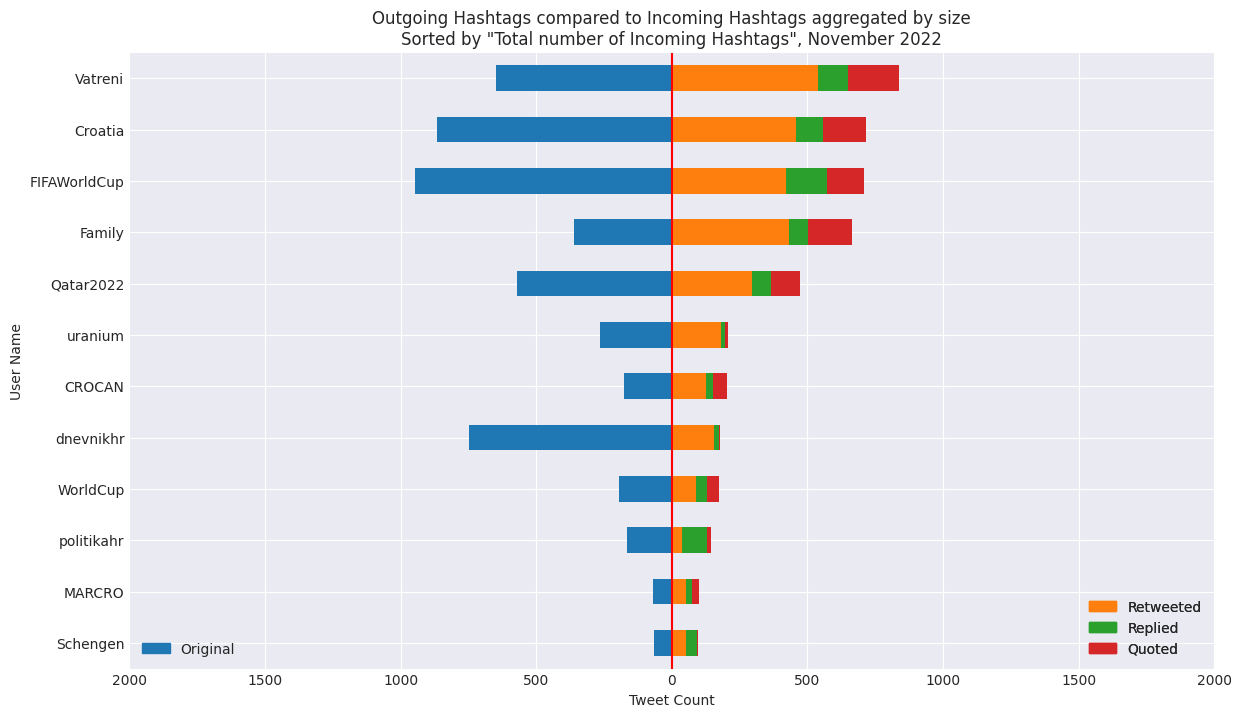

In [5]:
sorted_by = 'total_in_tweets_cnt'
top_in_tweets_hashtags = hashtags_view.groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])
MAX_X = top_in_tweets_hashtags.original_tweets_cnt.max() + (top_in_tweets_hashtags.original_tweets_cnt.max() * .1)

PLOT_CONFIG['positive_cols'] = {
    'in_retweet_cnt': 'Retweeted', 
    'in_reply_cnt': 'Replied',     
    'in_quote_cnt': 'Quoted'
}

plot_top_tweet_hashtags(
    top_in_tweets_hashtags, 
    title=(
        'Outgoing Hashtags compared to Incoming Hashtags aggregated by size\n'
        'Sorted by "{}", November 2022').format(PLOT_CONFIG['total_cols'][sorted_by]), 
    max_x=MAX_X,
    export_plot_name='eps/hashtags-total-in-reactions.eps'
)

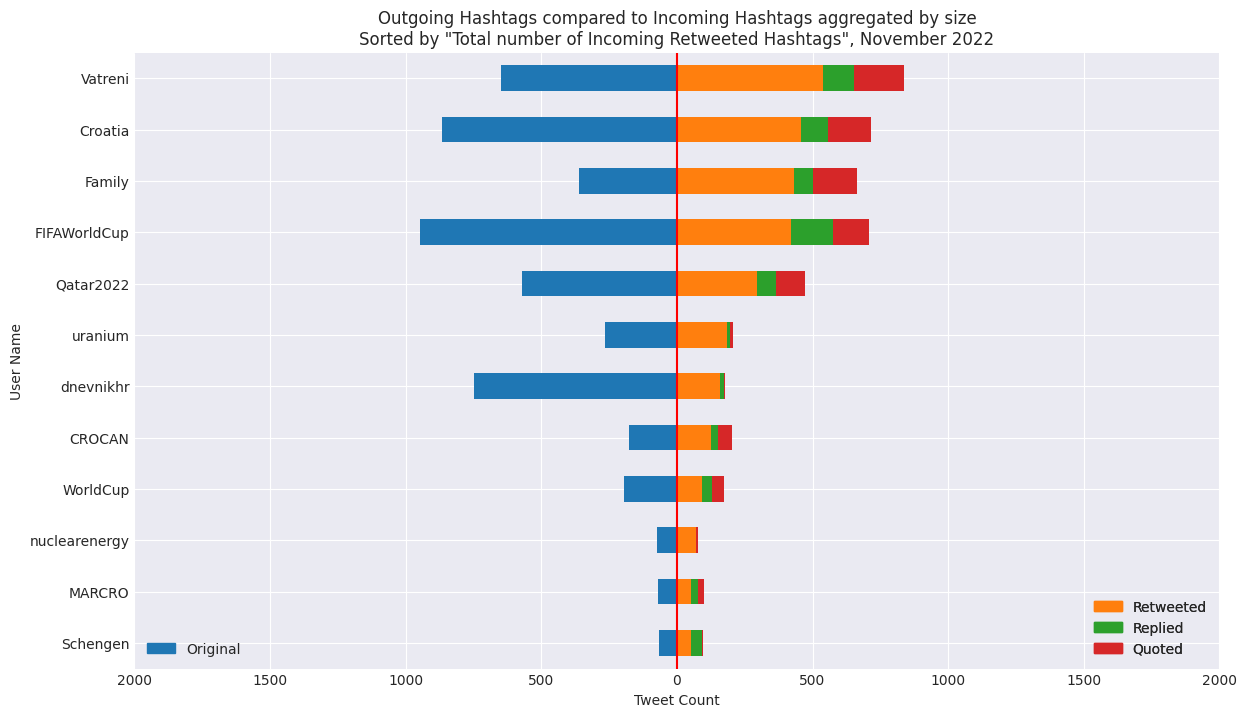

In [6]:
sorted_by = 'in_retweet_cnt'

# PLOT_CONFIG['positive_cols'] = {
#     'in_reply_cnt': 'Replied',     
#     'in_retweet_cnt': 'Retweeted', 
#     'in_quote_cnt': 'Quoted'
# }
top_in_retweet_hashtags = hashtags_view.groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

plot_top_tweet_hashtags(
    top_in_retweet_hashtags, 
    title=(
        'Outgoing Hashtags compared to Incoming Hashtags aggregated by size\n'
        'Sorted by "Total number of Incoming {} Hashtags", November 2022').format(PLOT_CONFIG['positive_cols'][sorted_by]), 
    max_x=MAX_X,
    export_plot_name='eps/hashtags-retweet-in-reactions.eps'
)

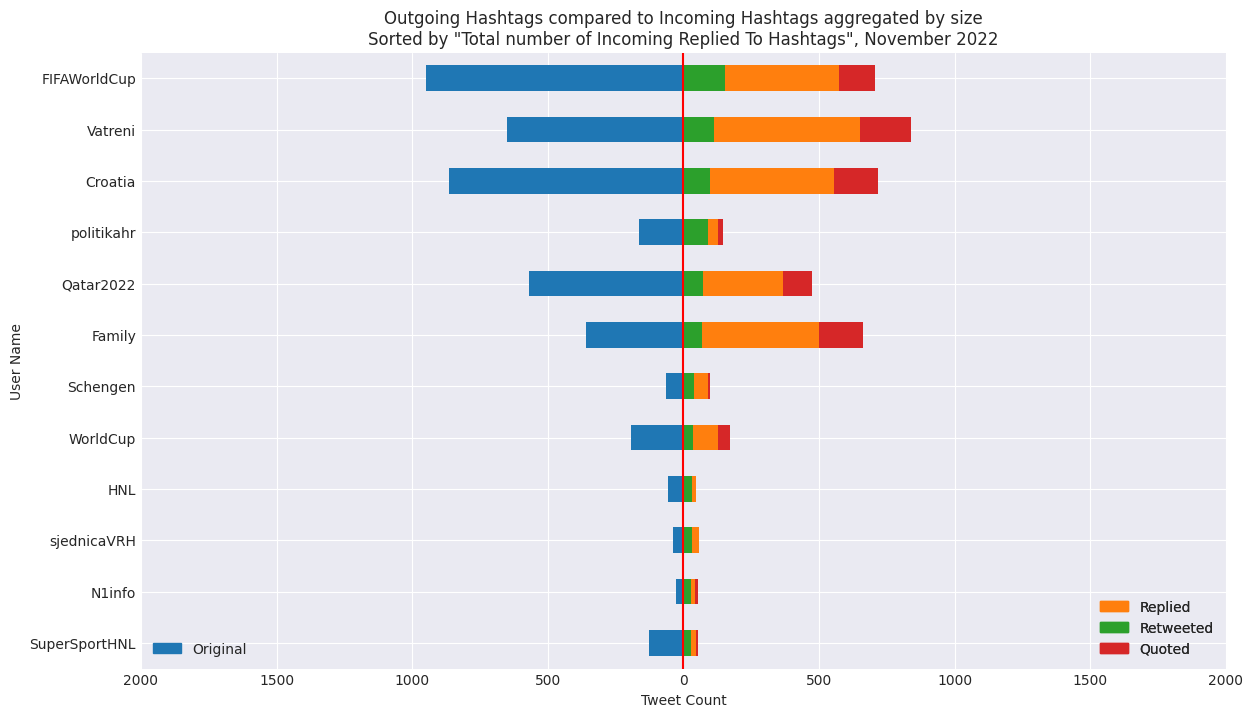

In [7]:
sorted_by = 'in_reply_cnt'

PLOT_CONFIG['inbound_cols'] = {
    'in_reply_cnt': 'Replied',     
    'in_retweet_cnt': 'Retweeted', 
    'in_quote_cnt': 'Quoted'
}
top_in_retweet_hashtags = hashtags_view.groupby('hashtag').agg(**AGGREGATE).sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

plot_top_tweet_hashtags(
    top_in_retweet_hashtags, 
    title=(
        'Outgoing Hashtags compared to Incoming Hashtags aggregated by size\n'
        'Sorted by "Total number of Incoming {} To Hashtags", November 2022').format(PLOT_CONFIG['inbound_cols'][sorted_by]), 
    max_x=MAX_X,
    export_plot_name='eps/hashtags-reply-in-reactions.eps'
)

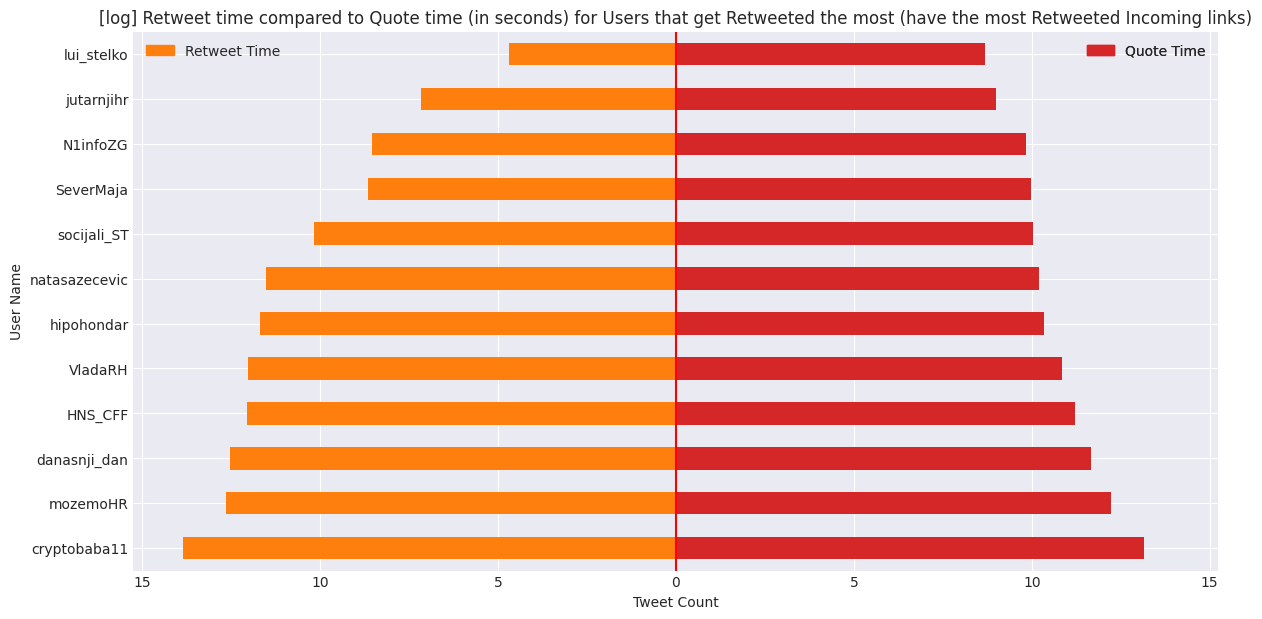

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 7))

# fastest_retweeted_hashtags = hashtags_view.groupby('hashtag').agg(**AGGREGATE).sort_values('in_retweet_timedelta_sec').tail(PLOT_CONFIG['plot_head'])
fastest_retweeted_hashtags = users_view.set_index(USER_DISPLAY_NAME).sort_values(by='in_retweet_cnt').tail(PLOT_CONFIG['plot_head']).sort_values('in_retweet_timedelta_sec')
fastest_retweeted_hashtags = fastest_retweeted_hashtags[['in_retweet_timedelta_sec']].dropna()[::-1]
fastest_retweeted_hashtags['in_retweet_timedelta_sec'] = (np.log2(fastest_retweeted_hashtags['in_retweet_timedelta_sec'])*-1)

# fastest_quoted_hashtags = hashtags_view.groupby('hashtag').agg(**AGGREGATE).sort_values('in_quote_timedelta_sec').tail(PLOT_CONFIG['plot_head'])
fastest_quoted_hashtags = users_view.set_index(USER_DISPLAY_NAME).sort_values(by='in_quote_cnt').tail(PLOT_CONFIG['plot_head']).sort_values('in_quote_timedelta_sec')
fastest_quoted_hashtags = fastest_quoted_hashtags[['in_quote_timedelta_sec']].dropna()[::-1]
fastest_quoted_hashtags['in_quote_timedelta_sec'] = np.log2(fastest_quoted_hashtags['in_quote_timedelta_sec'])

fastest_retweeted_hashtags.plot.barh(
    ax=ax, 
    stacked=True,
    color=default_colors[1]
)
legend_1 = plt.legend(['Retweet Time'], loc='upper left')
legend_1.legendHandles[0].set_color(default_colors[1])

fastest_quoted_hashtags.plot.barh(ax=ax, stacked=True, color=default_colors[3])
legend_2 = plt.legend(['Quote Time'], loc='upper right')
legend_2.legendHandles[0].set_color(default_colors[3])

ax.add_artist(legend_1)
ax.add_artist(legend_2)
ax.set_title(
    '[log] Retweet time compared to Quote time (in seconds) '
    'for Users that get Retweeted the most (have the most Retweeted Incoming links)')
ax.set_xlabel('Tweet Count')
ax.set_ylabel('User Name')
min_x = fastest_retweeted_hashtags['in_retweet_timedelta_sec'].min() + (fastest_retweeted_hashtags['in_retweet_timedelta_sec'].min() * .1)
ax.set_xlim(min_x, min_x*-1)
ax.axvline(color='red')
ticks = ax.get_xticks()
ax.set_xticklabels([int(abs(tick)) for tick in ticks])
plt.savefig('eps/hashtags-retweet-in-timedelta.eps', format='eps', dpi=200)

# plt.xticks(rotation=30)
plt.show()


In [9]:
time_hashtag_cnts = tweets_view.explode(HASHTAG_COLUMN_NAME) \
    .rename(
        columns={HASHTAG_COLUMN_NAME: 'hashtag'}
    ).groupby(['year', 'month', 'week', 'day', 'day_name', 'hashtag']).agg(
        hashtag_cnt=('hashtag', 'size'), 
        unique_user_cnt=('screen_name', 'nunique'),
        favorite_cnt=('original_favorite_cnt', 'sum'),
        
        total_out_tweets_cnt=('hashtag', 'size'),
        total_in_tweets_cnt=('total_in_tweets_cnt', 'sum'),
        original_tweets_cnt=('is_original', 'sum'),
        out_retweet_cnt=('is_retweet', 'sum'),
        out_reply_cnt=('is_reply', 'sum'),
        out_quote_cnt=('is_quote', 'sum'),

        in_retweet_cnt=('in_retweet_cnt', 'sum'),
        in_reply_cnt=('in_reply_cnt', 'sum'),
        in_quote_cnt=('in_quote_cnt', 'sum'),
        in_retweet_favorite_cnt=('retweet_favorite_cnt', 'sum'),
        in_quote_favorite_cnt=('quote_favorite_cnt', 'sum'),    
        
        in_retweet_timedelta_sec=('in_retweet_timedelta_sec', 'mean'),
        in_quote_timedelta_sec=('in_quote_timedelta_sec', 'mean')        
    )


In [10]:
time_hashtag_cnts['alpha'] = time_hashtag_cnts['unique_user_cnt'] / time_hashtag_cnts['hashtag_cnt']
time_hashtag_cnts['beta']  = time_hashtag_cnts['hashtag_cnt'] / time_hashtag_cnts['hashtag_cnt'].sum()
time_hashtag_cnts['gamma'] = time_hashtag_cnts['favorite_cnt']

# time_hashtag_cnts = time_hashtag_cnts.sort_values('unique_user_cnt', ascending=False).head(20)

time_hashtag_cnts['alpha_n'] = time_hashtag_cnts['alpha'] * (1 / max(time_hashtag_cnts['alpha']))
time_hashtag_cnts['beta_n']  = time_hashtag_cnts['beta'] * (1 / max(time_hashtag_cnts['beta']))
time_hashtag_cnts['gamma_n'] = time_hashtag_cnts['gamma'] * (1 / max(time_hashtag_cnts['gamma']))

In [11]:
AGGREGATE = dict(
    total_hashtag_cnt=('hashtag_cnt', 'sum'),
    total_favorite_cnt=('favorite_cnt', 'sum'),
    total_unique_user_cnt=('unique_user_cnt', 'sum'),
    
    total_out_tweets_cnt=('total_out_tweets_cnt', 'sum'),
    total_in_tweets_cnt=('total_in_tweets_cnt', 'sum'),
    
    original_tweets_cnt=('original_tweets_cnt', 'sum'),
    out_retweet_cnt=('out_retweet_cnt', 'sum'),
    out_reply_cnt=('out_reply_cnt', 'sum'),
    out_quote_cnt=('out_quote_cnt', 'sum'),
    out_favorite_cnt=('favorite_cnt', 'sum'),

    in_retweet_cnt=('in_retweet_cnt', 'sum'),
    in_reply_cnt=('in_reply_cnt', 'sum'),
    in_quote_cnt=('in_quote_cnt', 'sum'),
    in_retweet_favorite_cnt=('in_retweet_favorite_cnt', 'sum'),
    in_quote_favorite_cnt=('in_quote_favorite_cnt', 'sum'),    
    
    in_retweet_timedelta_sec=('in_retweet_timedelta_sec', 'mean'),
    in_quote_timedelta_sec=('in_quote_timedelta_sec', 'mean')
)

total_hashtag_cnts = time_hashtag_cnts.groupby('hashtag').agg(**AGGREGATE)

total_hashtag_cnts['alpha'] = total_hashtag_cnts['total_unique_user_cnt'] / total_hashtag_cnts['total_hashtag_cnt']
total_hashtag_cnts['beta']  = total_hashtag_cnts['total_hashtag_cnt'] / total_hashtag_cnts['total_hashtag_cnt'].sum()
total_hashtag_cnts['gamma'] = total_hashtag_cnts['total_favorite_cnt']

total_hashtag_cnts['alpha_n'] = total_hashtag_cnts['alpha'] * (1 / max(total_hashtag_cnts['alpha']))
total_hashtag_cnts['beta_n']  = total_hashtag_cnts['beta'] * (1 / max(total_hashtag_cnts['beta']))
total_hashtag_cnts['gamma_n'] = total_hashtag_cnts['gamma'] * (1 / max(total_hashtag_cnts['gamma']))

time_hashtag_cnts['alpha'] = time_hashtag_cnts.index.to_series().apply(lambda x: total_hashtag_cnts.alpha.get(x[4], 0))
time_hashtag_cnts['beta'] = time_hashtag_cnts.index.to_series().apply(lambda x: total_hashtag_cnts.beta.get(x[4], 0))
time_hashtag_cnts['gamma'] = time_hashtag_cnts.index.to_series().apply(lambda x: total_hashtag_cnts.gamma.get(x[4], 0))

time_hashtag_cnts['alpha_n'] = time_hashtag_cnts['alpha'] * (1 / time_hashtag_cnts['alpha'])
time_hashtag_cnts['beta_n'] = time_hashtag_cnts['beta'] * (1 / time_hashtag_cnts['beta'])
time_hashtag_cnts['gamma_n'] = time_hashtag_cnts['gamma'] * (1 / time_hashtag_cnts['gamma'])

total_hashtag_cnts.sort_values('total_unique_user_cnt', ascending=False).head(20)

,total_hashtag_cnt,total_favorite_cnt,total_unique_user_cnt,total_out_tweets_cnt,total_in_tweets_cnt,original_tweets_cnt,out_retweet_cnt,out_reply_cnt,out_quote_cnt,out_favorite_cnt,...,in_retweet_favorite_cnt,in_quote_favorite_cnt,in_retweet_timedelta_sec,in_quote_timedelta_sec,alpha,beta,gamma,alpha_n,beta_n,gamma_n
hashtag,,,,,,,,,,,,,,,,,,,,,
Croatia,1574,62512,1033,1574,716.0,865,709,31,247,62512,...,837635.0,727736.0,3104.989460,292.470743,0.656290,0.011038,62512,0.656290,0.772705,0.718397
FIFAWorldCup,2037,58774,968,2037,707.0,948,1089,9,306,58774,...,41000335.0,5908274.0,518.641105,335.264661,0.475209,0.014286,58774,0.475209,1.000000,0.675439
Qatar2022,1160,39072,602,1160,474.0,570,590,12,181,39072,...,21613949.0,1521241.0,572.714626,304.826675,0.518966,0.008135,39072,0.518966,0.569465,0.449021
Vatreni,1238,87016,579,1238,838.0,649,589,13,220,87016,...,642225.0,637670.0,3402.965980,844.027670,0.467690,0.008682,87016,0.467690,0.607757,1.000000
Family,802,69788,433,802,663.0,360,442,3,172,69788,...,619849.0,349323.0,3269.087724,850.946658,0.539900,0.005624,69788,0.539900,0.393716,0.802013
croatia,774,1918,398,774,41.0,671,103,9,43,1918,...,48026.0,29467.0,455.968981,117.713167,0.514212,0.005428,1918,0.514212,0.379971,0.022042
Ukraine,672,1076,332,672,25.0,176,496,16,88,1076,...,1329190.0,248279.0,1430.791772,1.600000,0.494048,0.004713,1076,0.494048,0.329897,0.012366
Zagreb,352,6147,276,352,54.0,236,116,11,19,6147,...,13174.0,472.0,1991.728122,446.658333,0.784091,0.002469,6147,0.784091,0.172803,0.070642
WorldCup,368,23689,245,368,173.0,195,173,2,57,23689,...,3464826.0,198906.0,2358.697029,346.003416,0.665761,0.002581,23689,0.665761,0.180658,0.272237


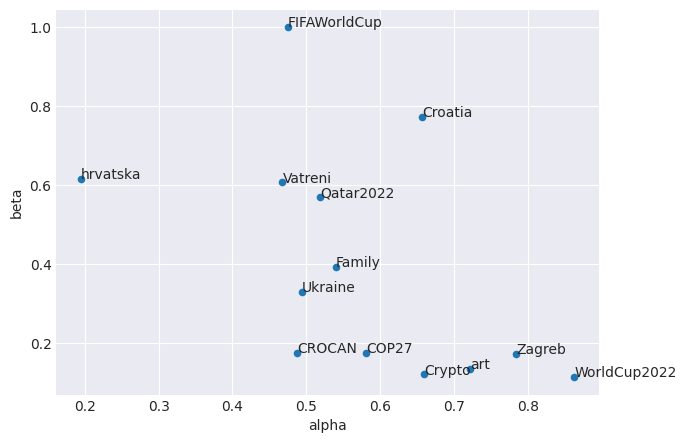

In [22]:
fig, ax1 = plt.subplots(1, figsize=(7, 5))
drop_hashtags = ['croatia', 'photography', 'F1', 'Bitcoin', 'WorldCup', 'NFT', 'crypto']

plot_hashtag_cnts = total_hashtag_cnts.sort_values('total_unique_user_cnt', ascending=False).head(20)
# ax1 = fig.add_subplot(projection='3d')
# ax1.scatter(plot_hashtag_cnts['alpha_n'], plot_hashtag_cnts['beta_n'], plot_hashtag_cnts['gamma_n'])

plot_hashtag_cnts.drop(drop_hashtags).plot.scatter(x='alpha_n', y='beta_n', ax=ax1)
# ax1.set_title('(b)', loc='left')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
# ax1.set_zlabel('Favorite Count')

# Annotate each data point
for i in plot_hashtag_cnts.drop(drop_hashtags).index:
    ax1.text(plot_hashtag_cnts.alpha_n.get(i), plot_hashtag_cnts.beta_n.get(i), s=i)#, plot_hashtag_cnts.gamma_n.get(i), i)

# ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# ax2.scatter(plot_hashtag_cnts['alpha'], plot_hashtag_cnts['beta'], plot_hashtag_cnts['gamma2'])

# ax2.set_xlabel('alpha')
# ax2.set_ylabel('beta')
# ax2.set_zlabel('Followers Count')

# # Annotate each data point
# for i in plot_hashtag_cnts.index:
#     ax2.text(plot_hashtag_cnts.alpha.get(i), plot_hashtag_cnts.beta.get(i), plot_hashtag_cnts.gamma2.get(i), i)

plt.savefig('eps/figure-8.eps', format='eps', dpi=200,bbox_inches='tight')
plt.show()

In [15]:
plot_hashtag_cnts.drop(['croatia', 'art', 'F1', 'Bitcoin'])

,total_hashtag_cnt,total_favorite_cnt,total_unique_user_cnt,total_out_tweets_cnt,total_in_tweets_cnt,original_tweets_cnt,out_retweet_cnt,out_reply_cnt,out_quote_cnt,out_favorite_cnt,...,in_retweet_favorite_cnt,in_quote_favorite_cnt,in_retweet_timedelta_sec,in_quote_timedelta_sec,alpha,beta,gamma,alpha_n,beta_n,gamma_n
hashtag,,,,,,,,,,,,,,,,,,,,,
Croatia,1574,62512,1033,1574,716.0,865,709,31,247,62512,...,837635.0,727736.0,3104.989460,292.470743,0.656290,0.011038,62512,0.656290,0.772705,0.718397
FIFAWorldCup,2037,58774,968,2037,707.0,948,1089,9,306,58774,...,41000335.0,5908274.0,518.641105,335.264661,0.475209,0.014286,58774,0.475209,1.000000,0.675439
Qatar2022,1160,39072,602,1160,474.0,570,590,12,181,39072,...,21613949.0,1521241.0,572.714626,304.826675,0.518966,0.008135,39072,0.518966,0.569465,0.449021
Vatreni,1238,87016,579,1238,838.0,649,589,13,220,87016,...,642225.0,637670.0,3402.965980,844.027670,0.467690,0.008682,87016,0.467690,0.607757,1.000000
Family,802,69788,433,802,663.0,360,442,3,172,69788,...,619849.0,349323.0,3269.087724,850.946658,0.539900,0.005624,69788,0.539900,0.393716,0.802013
Ukraine,672,1076,332,672,25.0,176,496,16,88,1076,...,1329190.0,248279.0,1430.791772,1.600000,0.494048,0.004713,1076,0.494048,0.329897,0.012366
Zagreb,352,6147,276,352,54.0,236,116,11,19,6147,...,13174.0,472.0,1991.728122,446.658333,0.784091,0.002469,6147,0.784091,0.172803,0.070642
WorldCup,368,23689,245,368,173.0,195,173,2,57,23689,...,3464826.0,198906.0,2358.697029,346.003416,0.665761,0.002581,23689,0.665761,0.180658,0.272237
hrvatska,1256,1422,245,1256,39.0,1216,40,2,14,1422,...,2409.0,301.0,502.732128,227.783360,0.195064,0.008808,1422,0.195064,0.616593,0.016342


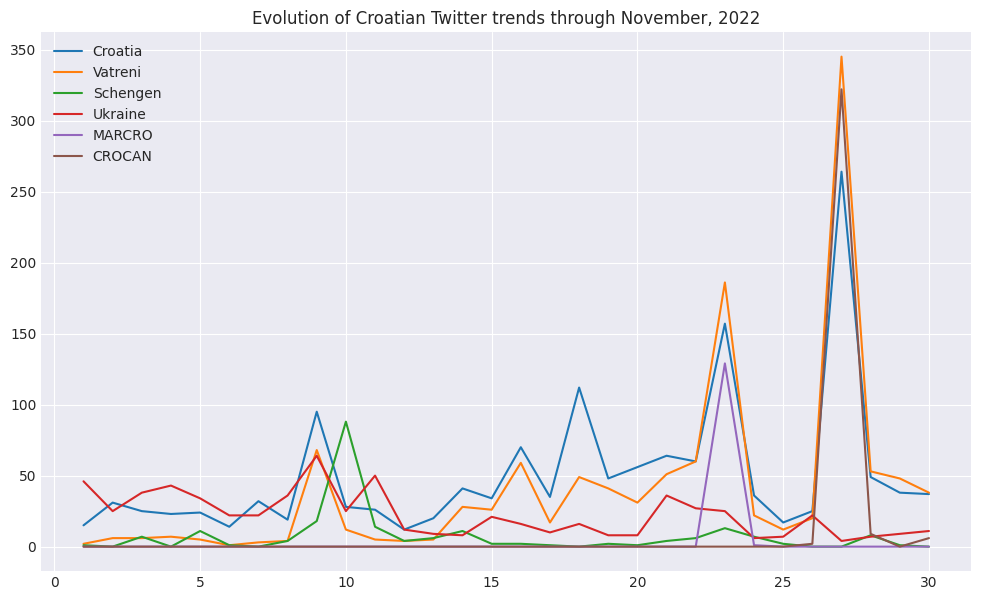

In [13]:
labels = ['Croatia', 'Vatreni', 'Schengen', 'Ukraine',  'MARCRO', 'CROCAN']
# labels = ['Schengen']

time_hashtag_cnts_pivot = time_hashtag_cnts.loc[(slice(None), slice(None), slice(None), slice(None), slice(None), labels), ['hashtag_cnt']].pivot_table('hashtag_cnt', index='day', columns=['hashtag']).fillna(0)
time_hashtag_cnts_pivot = time_hashtag_cnts_pivot[labels]

# from scipy.interpolate import interp1d
# filtered_pivot_df = time_hashtag_cnts_pivot.loc[time_hashtag_cnts_pivot.index.to_series().apply(lambda x: x % 2 == 0)]
# new_x = np.arange(time_hashtag_cnts_pivot.index.min(), time_hashtag_cnts_pivot.index.max())
# interp_df = pd.DataFrame()
# x = filtered_pivot_df.index.get_level_values('day')
# for col_name in time_hashtag_cnts_pivot.columns:
#     y = filtered_pivot_df[col_name]
#     f = interp1d(x, y, kind='cubic')
#     interp_df[col_name] = f(new_x)
# interp_df.index = new_x

ax = time_hashtag_cnts_pivot.plot.line(title='Evolution of Croatian Twitter trends through November, 2022', figsize=(12, 7))
ax.legend(labels, title=None)
ax.set_xlabel(None)
plt.savefig('eps/hashtags-evolution-daily-202211.eps', format='eps', dpi=200)
plt.show()

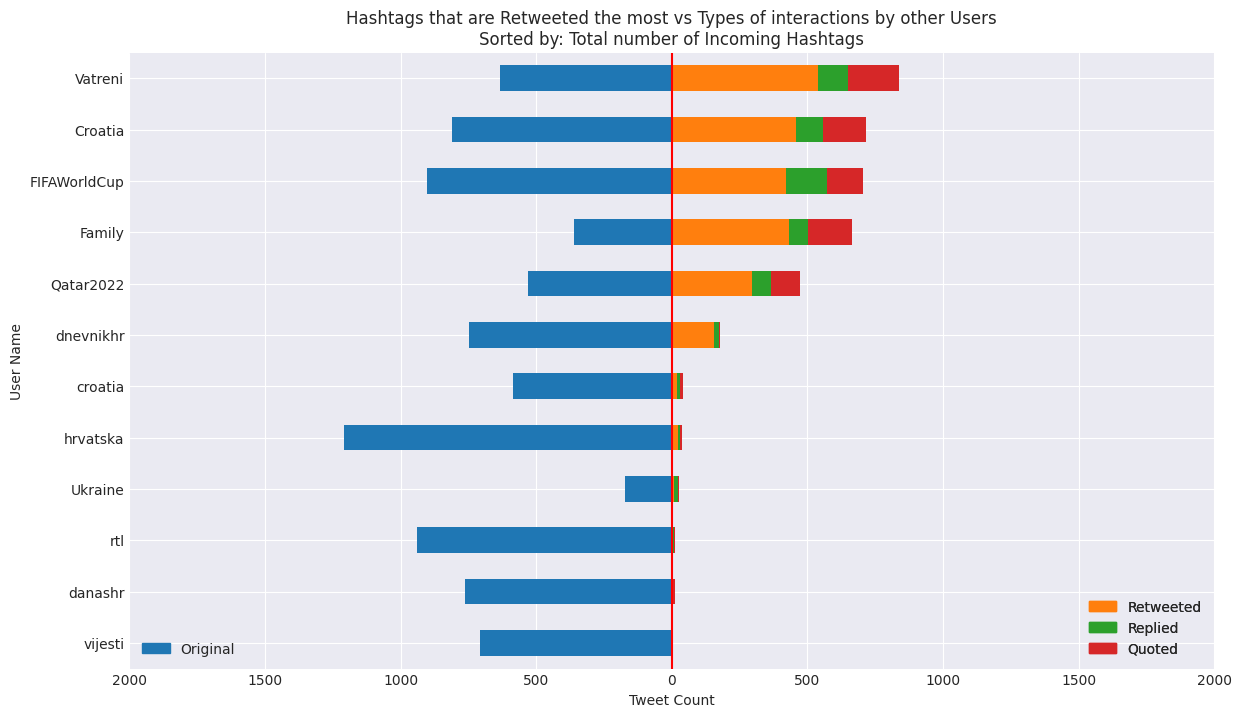

In [14]:
sorted_by = 'total_in_tweets_cnt'

PLOT_CONFIG['inbound_cols'] = {
    'in_retweet_cnt': 'Retweeted', 
    'in_reply_cnt': 'Replied',
    'in_quote_cnt': 'Quoted'
}
top_in_tweet_hashtags = total_hashtag_cnts[
    (total_hashtag_cnts['beta_n'] > 0.33)
].sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])
MAX_X = top_in_tweet_hashtags.original_tweets_cnt.max()

plot_top_tweet_hashtags(
    top_in_tweet_hashtags, 
    title=(
        'Hashtags that are Retweeted the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {}').format(PLOT_CONFIG['total_cols'][sorted_by]), 
    max_x=MAX_X,
    # export_plot_name='eps/hashtags-popular-reply-interactions.eps'
)

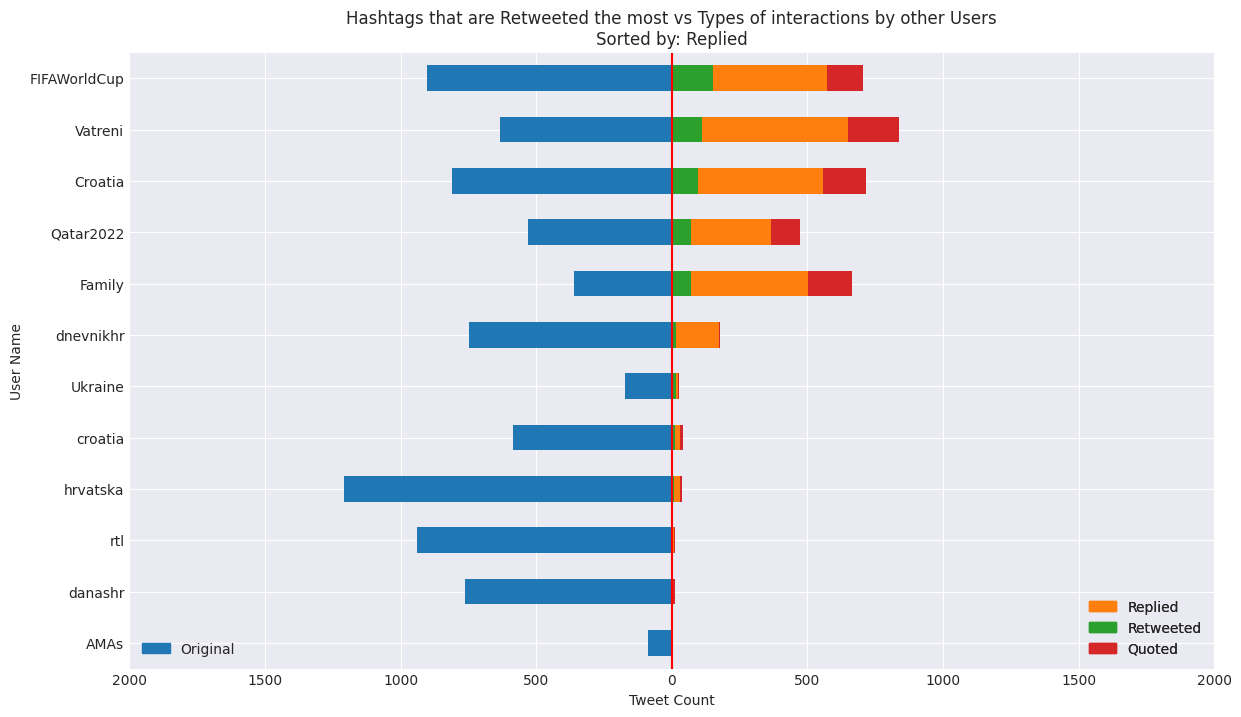

In [15]:
sorted_by = 'in_reply_cnt'

PLOT_CONFIG['inbound_cols'] = {
    'in_reply_cnt': 'Replied',
    'in_retweet_cnt': 'Retweeted', 
    'in_quote_cnt': 'Quoted'
}
top_in_retweet_hashtags = total_hashtag_cnts[
    (total_hashtag_cnts['beta_n'] > 0.33)
].sort_values(sorted_by).tail(PLOT_CONFIG['plot_head'])

plot_top_tweet_hashtags(
    top_in_retweet_hashtags, 
    title=(
        'Hashtags that are Retweeted the most '
        'vs Types of interactions by other Users\n'
        'Sorted by: {}').format(PLOT_CONFIG['inbound_cols'][sorted_by]), 
    max_x=MAX_X,
    # export_plot_name='eps/hashtags-popular-reply-interactions.eps'
)

In [16]:
N = 75
top_N_hashtag_cnts = total_hashtag_cnts.sort_values('total_unique_user_cnt', ascending=False).head(N)
top_N_hashtags = top_N_hashtag_cnts.index
top_N_hashtag_cnts

,total_hashtag_cnt,total_favorite_cnt,total_unique_user_cnt,total_out_tweets_cnt,total_in_tweets_cnt,original_tweets_cnt,out_retweet_cnt,out_reply_cnt,out_quote_cnt,out_favorite_cnt,...,in_retweet_favorite_cnt,in_quote_favorite_cnt,in_retweet_timedelta_sec,in_quote_timedelta_sec,alpha,beta,gamma,alpha_n,beta_n,gamma_n
hashtag,,,,,,,,,,,,,,,,,,,,,
Croatia,1507,62078,988,1507,716,809,698,31,244,62078,...,831282.0,726616.0,3314.693827,309.421798,0.655607,0.010979,62078,0.655607,0.764199,0.713516
FIFAWorldCup,1972,58629,936,1972,706,901,1071,8,299,58629,...,40964664.0,5857242.0,527.229195,342.888304,0.474645,0.014367,58629,0.474645,1.000000,0.673873
Qatar2022,1107,39042,581,1107,474,529,578,11,179,39042,...,21594773.0,1520358.0,584.657705,322.540292,0.524842,0.008065,39042,0.524842,0.561359,0.448743
Vatreni,1214,87003,569,1214,838,635,579,13,219,87003,...,634993.0,637075.0,3415.623727,861.462258,0.468699,0.008845,87003,0.468699,0.615619,1.000000
Family,791,69788,425,791,663,359,432,3,171,69788,...,612784.0,348728.0,3297.675255,858.316027,0.537295,0.005763,69788,0.537295,0.401116,0.802133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jin,124,0,69,124,0,4,120,0,5,0,...,33232073.0,1501539.0,0.000000,0.000000,0.556452,0.000903,0,0.556452,0.062880,0.000000
AbuDhabiGP,135,14,69,135,1,30,105,0,21,14,...,3423771.0,389705.0,0.000000,0.000000,0.511111,0.000984,14,0.511111,0.068458,0.000161
dnevnikhr,1020,707,69,1020,178,747,273,0,6,707,...,486.0,9.0,237.796787,35.615683,0.067647,0.007431,707,0.067647,0.517241,0.008126


In [17]:
hashtags_retweeted = tweets_view[tweets_view['is_retweet']].explode('all_hashtags').rename(
    columns={'all_hashtags': 'hashtag'}
).dropna(subset='hashtag')[['hashtag', 'retweet_from_screen_name', 'screen_name']]
hashtags_retweeted

,hashtag,retweet_from_screen_name,screen_name
1198,ポケモンSV,sky_freedom_,toarueirei
3759,ウルトラマンジャスティス,PhotoHanabi,Herochange133
3760,ウルトラマンエース,obakelope0530,Herochange133
3760,シンウルトラマン,obakelope0530,Herochange133
3760,米津玄師,obakelope0530,Herochange133
...,...,...,...
959862,GoingNuclear,ScumGame,CubeSauce_dev
959862,Update,ScumGame,CubeSauce_dev
959862,Steam,ScumGame,CubeSauce_dev
959862,SALE,ScumGame,CubeSauce_dev


In [18]:
hashtags_original = tweets_view[tweets_view['is_original']].explode('all_hashtags').rename(
    columns={'all_hashtags': 'hashtag'}
).dropna(subset='hashtag')[['screen_name', 'hashtag']]
hashtags_original = hashtags_original[hashtags_original['screen_name'].isin(hashtags_retweeted['screen_name'])]
hashtags_original

,screen_name,hashtag
4360,Herochange133,FIFAWorldCup
5736,dramaticmimi,LiftMeUp
5773,dramaticmimi,AutumnDuraldArkapaw
5773,dramaticmimi,liftmeup
5785,dramaticmimi,ScreamMovie
...,...,...
959251,zadarski_list,FIFAWorldCup
959251,zadarski_list,Qatar2022
959251,zadarski_list,Family
959251,zadarski_list,Vatreni


In [19]:
retweet_edgelist = hashtags_retweeted.rename(
    columns={'retweet_from_screen_name': 'source', 'screen_name': 'target'}
)
for label in ['FIFAWorldCup', 'Croatia', 'Hrvatska', 'Qatar2022', 'Vatreni', 'Family', 'Ukraine', 'WorldCup2022', 'crypto', 'Schengen', 'COP27']:
    retweet_edgelist[retweet_edgelist['hashtag'] == label].to_csv('graph/diffusion/by_hashtag/edges-{}.csv'.format(label), index=False)
retweet_edgelist.to_csv('graph/diffusion/edges-retweets.csv', index=False)

In [20]:
original_edgelist = hashtags_original.rename(
    columns={'screen_name': 'source', 'hashtag': 'target'}
)
original_nodes = original_edgelist[['source']].rename(columns={'source': 'Id'})
original_nodes['node_type'] = 'user'
original_nodes = pd.concat((original_nodes, original_edgelist[['target']].rename(columns={'target': 'Id'})))
original_nodes['node_type'] = original_nodes['node_type'].fillna('hashtag')
original_nodes = original_nodes.drop_duplicates(subset='Id')
original_nodes.to_csv('graph/diffusion/nodes-original.csv', index=False)

original_edgelist[original_edgelist['target'].isin(top_N_hashtags[:20])].to_csv('graph/diffusion/edges-original-filtered.csv', index=False)

In [21]:
from statistics import mean
from math import ceil
import networkx as nx


def tuple_items(tupl, i=0):
    return [round(tup[i], 4) if isinstance(tup[i], float) else tup[i] for tup in tupl]

def sorted_dict(_dict, n=None, min_limit=0, avg_vals=False, reverse=True):
    if avg_vals:
        tuple_dict = ((k, ceil(mean(v))) for k, v in _dict.items() if mean(v) > min_limit)
    else:
        tuple_dict = ((k, v) for k, v in _dict.items() if v > min_limit)
    return sorted(tuple_dict, key=lambda x: x[1], reverse=reverse)[:n]

def _all_shortest_paths(graph):
    all_shortest_paths = {}
    for source in graph.nodes():
        available_paths = all_shortest_paths.get(source, [])
        for target in graph.nodes():
            try:
                asp = nx.all_shortest_paths(graph, source, target)
                available_paths.extend(list(map(len, asp)))
            except nx.NetworkXNoPath:
                continue
        all_shortest_paths[source] = sorted(available_paths, reverse=True)
    return all_shortest_paths

def get_graph_measures(G, subset):
    betweenness_centrality = nx.betweenness_centrality(G)
    clustering = nx.clustering(G)
    pagerank = nx.pagerank(G)
    central_betweenness_nodes = tuple_items(sorted_dict(betweenness_centrality))
    best_pagerank_nodes = tuple_items(sorted_dict(pagerank, n=7, min_limit=0.01))
    most_clustering_nodes = tuple_items(sorted_dict(clustering))
    least_clustering_nodes = tuple_items(sorted_dict(clustering, reverse=False))

    measures = {
        'nodes': len(G.nodes),
        'edges': len(G.edges),
        
        'density': nx.density(G),
        'avg_degree': mean(filter(lambda x: x > 0, tuple_items(G.degree(), i=1))),
        'avg_in_degree': mean(filter(lambda x: x > 0, tuple_items(G.in_degree(), i=1))),
        'avg_out_degree': mean(filter(lambda x: x > 0, tuple_items(G.out_degree(), i=1))),
        
        'betweenness_centrality_nodes': tuple_items(sorted_dict(betweenness_centrality), i=0),
        'best_pagerank_nodes': tuple_items(sorted_dict(pagerank, n=7, min_limit=0.01)),
        'most_clustering_nodes': tuple_items(sorted_dict(clustering)),
        'least_clustering_nodes': tuple_items(sorted_dict(clustering, reverse=False)),
        
        'avg_betweenness_centrality': mean(betweenness_centrality.values()),
        'betweenness_centrality': tuple_items(sorted_dict(betweenness_centrality), i=1),
        'best_pagerank': tuple_items(sorted_dict(pagerank, n=7, min_limit=0.01), i=1),
        'avg_clustering_coeff': tuple_items(sorted_dict(clustering), i=1)
    }
    if not nx.is_directed(G) and not nx.is_connected(G):
        measures['avg_shortest_paths'] = nx.average_shortest_path_length(G)
    if not subset == 'global':
        measures['all_paths'] = tuple_items(sorted_dict(_all_shortest_paths(G), avg_vals=True, reverse=True))
        
    index, data = measures.keys(), {subset: measures.values()}
    return pd.DataFrame(data, index=index)

In [22]:
G = nx.from_pandas_edgelist(
    retweet_edgelist, 
    create_using=nx.DiGraph
)
g = nx.subgraph_view(G, filter_node=lambda x: G.degree(x) > 1)
# global_measures_df = get_graph_measures(g, 'global')
# global_measures_df

In [23]:
stats_dfs = []
for hashtag in ['FIFAWorldCup', 'Vatreni', 'Croatia', 'Ukraine', 'Schengen', 'COP27']:
    G = nx.from_pandas_edgelist(
        retweet_edgelist[retweet_edgelist['hashtag'] == hashtag], 
        create_using=nx.DiGraph
    )
    g = nx.subgraph_view(G, filter_node=lambda x: G.degree(x) > 1)
    stats_dfs.append(get_graph_measures(g, hashtag))
stats_df = pd.concat(stats_dfs, axis=1)
stats_df

,FIFAWorldCup,Vatreni,Croatia,Ukraine,Schengen,COP27
nodes,160,46,103,88,21,58
edges,281,78,142,111,36,55
density,0.011046,0.037681,0.013516,0.014498,0.085714,0.016636
avg_degree,3.823129,3.391304,3.086957,2.846154,3.428571,2.5
avg_in_degree,2.67619,2.052632,2.088235,3.083333,3,2.5
avg_out_degree,5.854167,6,3.641026,2.466667,3,2.115385
betweenness_centrality_nodes,"[HNS_CFF, CroatiaFooty, _andrej45, CroatiaSck]","[HNS_CFF, CroatiaFooty, _andrej45]","[Croatia_hr, HNS_CFF, SibenikTB, StateOfCroati...",[],"[KarloRessler, VladaRH, HDZmladez]","[HDZ_HR, davorfilipovic2]"
best_pagerank_nodes,"[realMarioHren, ciglobacac, jksstrandofhair, F...","[Lela2609VuCro, IvankaSCK, NogometPlusNet, Prv...","[Lela2609VuCro, capnek123, CroatiaFerries, bam...","[Helena_321, ZenoZokalj, NinoslavSafaric, Gora...","[HDZ_HR, NinoslavSafaric, OgnianZlatev, IvanCa...","[OgnianZlatev, Marina87251891, HDZ_HR, EK_Hrva..."
most_clustering_nodes,"[YaBoiBru, skoobiman, Invictadria, kataa2020, ...","[LikeZadar, Ella_2002_, AnchyH, Torquat2835287...","[LikeZadar, Ella_2002_, AnchyH, AmadriaPark, z...","[VladaRH, IvanCar47530225, AndrejPlenkovic]","[HrMarkom, VladaRH, EPPGroup, HDZmladez, IvanC...","[EC_AVService, crosol_platform, TimMcPhieEU, V..."
least_clustering_nodes,"[FIFAWorldCup, HNS_CFF, gookiebts, gwangiljo, ...","[HNS_CFF, _andrej45, CroatiaFooty, zmay_maya, ...","[HNS_CFF, StateOfCroatia, Marina87251891, Croa...","[AndrejPlenkovic, IvanCar47530225, VladaRH]","[NinoslavSafaric, KarloRessler, AndrejPlenkovi...","[HDZ_HR, OgnianZlatev, EK_Hrvatska, EC_AVServi..."


betweenness_centrality
best_pagerank
avg_clustering_coeff


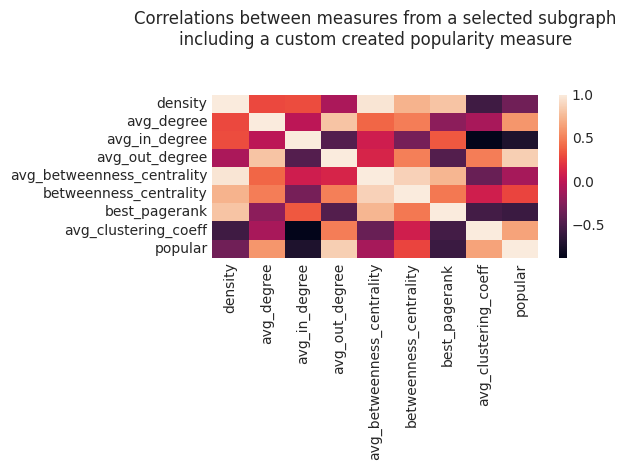

In [24]:
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

tstats_df = stats_df.T
for col_name in ['betweenness_centrality' ,'best_pagerank' ,'avg_clustering_coeff']:#, 'all_paths']:
    print(col_name)
    tstats_df[col_name] = tstats_df[col_name].transform(lambda x: mean(x) if x else 0)


htag_popular = {
    'FIFAWorldCup': True, 
    'Vatreni': True, 
    'Croatia': True, 
    'Ukraine': False, 
    'Schengen': False, 
    'COP27': False
}
tstats_df['popular'] = tstats_df.index.to_series().transform(lambda x: htag_popular[x])
tstats_df['density'] = tstats_df['density'].astype(float)
tstats_df['avg_degree'] = tstats_df['avg_degree'].astype(float)
tstats_df['avg_in_degree'] = tstats_df['avg_in_degree'].astype(float)
tstats_df['avg_out_degree'] = tstats_df['avg_out_degree'].astype(float)
tstats_df['avg_betweenness_centrality'] = tstats_df['avg_betweenness_centrality'].astype(float)

sns.heatmap(tstats_df.corr(numeric_only=True))
plt.title('Correlations between measures from a selected subgraph\nincluding a custom created popularity measure\n\n')
# plt.xticks(rotation=45)
plt.savefig('eps/graph-measures-correlation.eps', format='eps', dpi=200)
plt.show()

In [35]:
def df_format_decimal(df):
    format_df = df.copy()
    for col_name in df.columns:
        format_df.loc[:, col_name] = format_df[col_name].transform(lambda x: round(x, 4))
    return format_df

df_format_decimal(tstats_df[
    ['avg_degree', 'avg_in_degree', 'avg_out_degree', 'avg_betweenness_centrality', 'avg_clustering_coeff', 'betweenness_centrality', 'best_pagerank',  'density', 'popular']
].corr(numeric_only=True))#.style.to_latex('correlation-matrix.tex')


,avg_degree,avg_in_degree,avg_out_degree,avg_betweenness_centrality,avg_clustering_coeff,betweenness_centrality,best_pagerank,density,popular
avg_degree,1.0000,-0.0127,0.8033,0.3901,-0.1040,0.4882,-0.2160,0.2799,0.5936
avg_in_degree,-0.0127,1.0000,-0.4716,0.0727,-0.8858,-0.3122,0.3393,0.2963,-0.7343
avg_out_degree,0.8033,-0.4716,1.0000,0.1195,0.4877,0.4943,-0.4805,-0.0845,0.8535
avg_betweenness_centrality,0.3901,0.0727,0.1195,1.0000,-0.3781,0.8708,0.7365,0.9650,-0.1093
avg_clustering_coeff,-0.1040,-0.8858,0.4877,-0.3781,1.0000,0.0857,-0.5542,-0.5694,0.6508
betweenness_centrality,0.4882,-0.3122,0.4943,0.8708,0.0857,1.0000,0.4665,0.7257,0.2703
best_pagerank,-0.2160,0.3393,-0.4805,0.7365,-0.5542,0.4665,1.0000,0.8024,-0.5966
density,0.2799,0.2963,-0.0845,0.9650,-0.5694,0.7257,0.8024,1.0000,-0.3435
popular,0.5936,-0.7343,0.8535,-0.1093,0.6508,0.2703,-0.5966,-0.3435,1.0000


In [ ]:
import networkx as nx

stats_dfs = []
for htag in ['FIFAWorldCup', 'Croatia', 'Qatar2022', 'Vatreni', 'Family', 'Ukraine', 'WorldCup2022', 'crypto', 'COP27']:
    G = nx.from_pandas_edgelist(retweet_edgelist[retweet_edgelist['hashtag'] == htag].groupby(['source', 'target']).agg(count=('source', 'size')).reset_index(), edge_attr='count')
    stats_dfs.append(graph_global_measures(G, htag))
pd.concat(stats_dfs, axis=1)

,FIFAWorldCup,Croatia,Qatar2022,Vatreni,Family,Ukraine,WorldCup2022,crypto,COP27
total_nodes,494.000000,371.000000,295.000000,178.000000,134.000000,251.000000,132.000000,123.000000,193.000000
total_edges,576.000000,371.000000,326.000000,206.000000,134.000000,249.000000,90.000000,87.000000,171.000000
ave_degree,2.331984,2.000000,2.210169,2.314607,2.000000,1.984064,1.363636,1.414634,1.772021
ave_strength_count,4.334008,3.730458,3.915254,6.488764,6.447761,3.916335,1.666667,2.569106,2.715026
edges_ave,1.165992,1.000000,1.105085,1.157303,1.000000,0.992032,0.681818,0.707317,0.886010
network_density,0.004730,0.005405,0.007518,0.013077,0.015038,0.007936,0.010409,0.011595,0.009229
shortest_path_len,3.419262,3.482151,3.115929,2.469604,2.043542,5.622013,3.318841,3.356061,3.568182
diameter,11.000000,9.000000,7.000000,7.000000,5.000000,15.000000,6.000000,8.000000,8.000000
reach,0.287463,0.314276,0.334029,0.456238,0.492148,0.177992,0.078078,0.148703,0.098824
global_efficiency,0.177723,0.144049,0.221525,0.411674,0.498994,0.095632,0.023658,0.035840,0.031896


In [ ]:

community_size = len(retweet_edgelist[retweet_edgelist['hashtag'] == 'FIFAWorldCup']['FIFAWorldCup'].unique())
fig, axs = plt.subplots(nrows=community_size, ncols=2, figsize=(20, 7*community_size))

for i, hashtag in enumerate(retweet_edgelist[retweet_edgelist['hashtag'] == 'FIFAWorldCup']['FIFAWorldCup'].unique()):
    g = nx.from_pandas_edgelist(retweet_edgelist[(retweet_edgelist['hashtag'] == hashtag)], 'source', 'target')
    nx.draw(g, ax=axs[i][0])
    axs[i][0].set_title("Zajednica: {}".format(hashtag))
    measures_df = get_measures_df(g)
    axs[i][1].table(cellText=measures_df.values, rowLabels=measures_df.index, colLabels=['Iznos'], loc='center')
    


fig.tight_layout()
plt.plot()

KeyError: 'FIFAWorldCup'

## Hashtag - Hashtag Graph

In [ ]:
htag_view = tweets_view[tweets_view.all_hashtags.apply(lambda x: True if x else False)].copy()
# htag_view['all_hashtags'] = tweets_view['all_hashtags'].transform(lambda x: x if x else None)
htag_view = htag_view[['all_hashtags']].dropna()
htag_view['source_to_target'] = htag_view['all_hashtags'].transform(lambda x: [(x[i], x[i+1]) for i in range(0, len(x)-1, 2)] if len(x) > 1 else None)
htag_view = htag_view.explode('source_to_target').dropna(subset=['source_to_target'])
htag_view['source'] = htag_view['source_to_target'].transform(lambda x: x[0])
htag_view['target'] = htag_view['source_to_target'].transform(lambda x: x[1])
htag_view = htag_view[htag_view['source'].isin(total_hashtag_cnts.sort_values('beta', ascending=False).head(75).index)]
htag_view[['source', 'target']].to_csv('graph/edges-hashtags-hashtags.csv', index=False)